# Sprint 機械学習スクラッチ SVM

In [2]:
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [4]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X_sample1 = np.concatenate((f0, f1))
y_sample1 = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X_sample1 = X_sample1[random_index]
y_sample1 = y_sample1[random_index]

In [5]:
X_train, X_test, y_train,y_test = train_test_split(X_sample1, y_sample1, test_size=0.3, random_state=0)

## 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 
λ
 を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。

## 【問題2】サポートベクターの決定
計算したラグランジュ乗数 
λ
 が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。

閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

## 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた 
f
(
x
)
 の符号が分類結果です。

## 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [3]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """
    
    def __init__(self, num_iter=10, lr=0.001, kernel='linear', threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        
    def _linear(self,data, i, j):
        return data[i].T @ data[j]
    

    def _lagrange(self, X_data, y_data, lamda):
        lamda_copy =  lamda.copy()
        for i in range(len(X_data)):
            gradient = 0
            for j in range(len(X_data)):
                gradient += lamda_copy[j]*y_data[i]*y_data[j]*self._linear(X_data, i, j)
                
            lamda[i] = lamda_copy[i] + self.lr*(1-gradient)
        
        for i in range(len(X_data)):
            if lamda[i] < 0:
                lamda[i] = 0
        
        return lamda
                
    

    def _detect_support_vector(self, X_data, y_data):
        self.SV_data = []
        self.SV_label = []
        self.SV_lamda= []
        m = len(X_data)
        for i in range(m):
            if self.lamda[i] > self.threshold:
                self.SV_data.append(X_data[i])
                self.SV_label.append(y_data[i])
                self.SV_lamda.append(self.lamda[i])
                
    
    
    def _linear_predict(self, X_test, i, n):
        return X_test[i].T @ self.SV_data[n]
            


    def fit(self, X, y, X_val=np.array([]) , y_val=np.array([])):
        """
        SVM分類器を学習する。検証用データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        self.lamda = np.random.rand(X.shape[0])
        
        for i in range(self.iter):
            self.lamda = self._lagrange(X, y, self.lamda)
        self._detect_support_vector(X, y)
        
        if X_val.size != 0:
            self.val_lamda = np.random.rand(X_val.shape[0])
            for i in range(self.iter):
                self.val_lamda = self._lagrange(X_val, y_val, self.val_lamda)
                
        
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            
            print("train data:", self.lamda)
            print("test data:", self.val_lamda)

    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        
        m_test = len(X)
        d = 0
        predict = []
        for i in range(m_test):
            for n in range(len(self.SV_data)):
                d += self.SV_lamda[n] * self.SV_label[n] * self._linear_predict(X, i, n)
            predict.append(d)
            d=0
            
        predict_result = []
        for i in predict:
            if i >=0:
                predict_result.append(1)
            else:
                predict_result.append(-1)
                
        return np.array(predict_result)

In [6]:
ssvm = ScratchSVMClassifier()

In [7]:
ssvm.fit(X_train,y_train)

In [8]:
y_pred = ssvm.predict(X_test)

In [14]:
print("accuracy:", precision_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
print("matrix\n:", confusion_matrix(y_test, y_pred))

accuracy: 1.0
precision: 1.0
recall: 1.0
matrix
: [[65  0]
 [ 0 85]]


## 【問題5】決定領域の可視化
決定領域を可視化してください。

以下の例のようにサポートベクターは異なる色で示してください。

In [10]:
def decision_region(X_train, y_train, model, step=0.01, title='decision region', 
                    xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は学習用データである。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train : ndarray, shape(n_samples,)
        学習用データの正解値
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), 
                                    np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)
    sv_data = np.array(model.SV_data)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i],
                    label=target_names[i], marker='o')
    plt.scatter(sv_data[:,0], sv_data[:, 1], color="y")
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

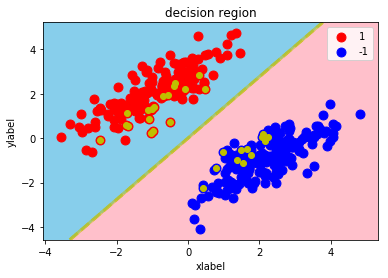

In [11]:
decision_region(X_train, y_train, ssvm, target_names=["1", "-1"])

In [12]:
ssvm_2 = ScratchSVMClassifier(num_iter=100, lr=0.001,threshold=1e-5)
ssvm_2.fit(X_train, y_train)

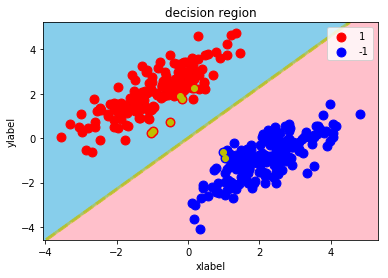

In [13]:
decision_region(X_train, y_train, ssvm_2, target_names=["1", "-1"])